# Oracle-MNIST Training



To run this you need to have the package 2dl installed: 
https://d2l.ai/chapter_installation/index.html


In [11]:
import torch
import numpy as np
from torch import nn
# from d2l import torch as d2l
import matplotlib.pyplot as plt
import torch.optim as optim


from utils import images_train, labels_train, images_test, labels_test

In [3]:
LR = 0.001 # Learning Rate
BATCH_SIZE_TRAINING = 256
BATCH_SIZE_VALIDATION = 36
NUM_EPOCHS = 10
TRAIN_VAL_SPLIT = 0.8

device = torch.device("cpu")

# LeNet

Read more about LeNet (LeCun et al 1998): https://d2l.ai/chapter_convolutional-neural-networks/lenet.html

In [4]:
def init_cnn(module):  #@save
    """Initialize weights for CNNs."""
    if type(module) == nn.Linear or type(module) == nn.Conv2d:
        # nn.init.xavier_uniform_(module.weight)
        nn.init.normal_(module.weight)

# class LeNet(d2l.Classifier):  #@save
#     """The LeNet-5 model."""
#     def __init__(self, lr=0.1, num_classes=10):
#         super().__init__()
#         self.save_hyperparameters()
#         self.net = nn.Sequential(
#             nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
#             nn.AvgPool2d(kernel_size=2, stride=2),
#             nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
#             nn.AvgPool2d(kernel_size=2, stride=2),
#             nn.Flatten(),
#             nn.LazyLinear(120), nn.Sigmoid(),
#             nn.LazyLinear(84), nn.Sigmoid(),
#             nn.LazyLinear(num_classes))
        
#     def layer_summary(self, X_shape):
#         X = torch.randn(*X_shape)
#         for layer in self.net:
#             X = layer(X)
#             print(layer.__class__.__name__, 'output shape:\t', X.shape)

class LeNet_scratch(nn.Module):  #@save
    """The LeNet-5 model implemented from scratch."""
    def __init__(self, lr=0.1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(120), nn.Sigmoid(),
            nn.LazyLinear(84), nn.Sigmoid(),
            nn.LazyLinear(num_classes))

        self.net.apply(init_cnn)
        
    def forward(self, X):
        predictions = self.net(X)
        return predictions
    
    def layer_summary(self, X_shape):
        X = torch.randn(*X_shape)
        for layer in self.net:
            X = layer(X)
            print(layer.__class__.__name__, 'output shape:\t', X.shape)


In [5]:
model = LeNet_scratch()

/Users/mnegro/opt/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Input image shape:	 torch.Size([256, 1, 28, 28])
Conv2d output shape:	 torch.Size([256, 6, 28, 28])
Sigmoid output shape:	 torch.Size([256, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([256, 6, 14, 14])
Conv2d output shape:	 torch.Size([256, 16, 10, 10])
Sigmoid output shape:	 torch.Size([256, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([256, 16, 5, 5])
Flatten output shape:	 torch.Size([256, 400])
Linear output shape:	 torch.Size([256, 120])
Sigmoid output shape:	 torch.Size([256, 120])
Linear output shape:	 torch.Size([256, 84])
Sigmoid output shape:	 torch.Size([256, 84])
Linear output shape:	 torch.Size([256, 10])


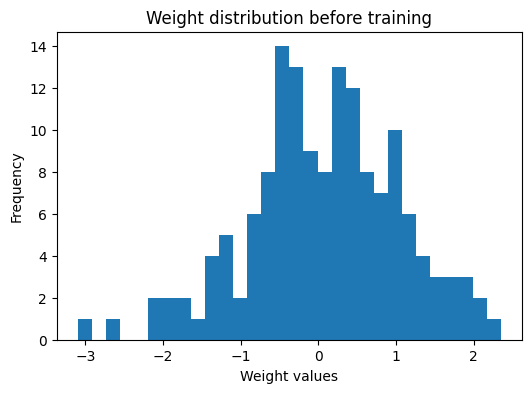

In [6]:
# Let's blug in an example that looks like our batched data:
# 256 images, 1 channel, 28x28 pixels
image_example = torch.randn(256, 1, 28, 28)  # Example image
print('Input image shape:\t', image_example.size())

model.layer_summary(image_example.size())

model.net.apply(init_cnn)

# plot the distribution of weights before training
plt.figure(figsize=(6, 4))
plt.hist(model.net[0].weight.data.numpy().flatten(), bins=30)
plt.title('Weight distribution before training')
plt.xlabel('Weight values')
plt.ylabel('Frequency')
plt.show()

# Define a DataLoader class

In [7]:
image_train_tensor = torch.tensor(images_train)
label_train_tensor = torch.tensor(labels_train)
image_test_tensor = torch.tensor(images_test)
label_test_tensor = torch.tensor(labels_test)

# Split the training data into training and validation sets
from torch.utils.data import TensorDataset, random_split, DataLoader

# I need to add the explicit dimension for the channel (1 for grayscale)
image_train_tensor = image_train_tensor.unsqueeze(1)
image_test_tensor = image_test_tensor.unsqueeze(1)
dataset = TensorDataset(image_train_tensor, label_train_tensor)
train_size = int(TRAIN_VAL_SPLIT * len(dataset))
val_size = len(dataset) - train_size
train_data, val_data = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_data, batch_size=BATCH_SIZE_TRAINING, shuffle=True)
valloader = DataLoader(val_data, batch_size=BATCH_SIZE_VALIDATION, shuffle=False)

In [8]:
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

# model.layer_summary((256, 1, 28, 28))

In [14]:
train_loss_ = []
val_loss_ = []

for epoch in range(1, NUM_EPOCHS+1):
    # print(f"\nEpoch {epoch}/{NUM_EPOCHS}")

    model.train()
    train_loss = 0
    # print(f"Training on {len(trainloader)} batches")
    for data_, label_ in trainloader:
        optimizer.zero_grad()
        data_ = data_.to(dtype=torch.float, device=device)
        outputs = model(data_)
        loss = criterion(outputs, label_.to(device))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    # if SCHEDULER:
    #     scheduler.step()
    train_loss = train_loss / len(trainloader)
    train_loss_.append(train_loss)

    # --- Validation ---
    model.eval()
    val_loss = 0
    # print(f"Validating on {len(valloader)} batches")
    with torch.no_grad():
        for data_, label_ in valloader:
            data_ = data_.to(dtype=torch.float, device=device)
            outputs = model(data_)
            loss = criterion(outputs, label_.to(device))
            val_loss += loss.item()
    val_loss /= len(valloader)
    val_loss_.append(val_loss)
    
    # --- Logging ---
    if epoch%2 == 0:
        print(f"epoch : {epoch}/{NUM_EPOCHS}; Validation loss = {round(val_loss, 6)}; Training loss = {round(train_loss, 6)}")

train_loss_ = np.array(train_loss_)
val_loss_ = np.array(val_loss_)

epoch : 2/10; Validation loss = 1.281882; Training loss = 1.265437
epoch : 4/10; Validation loss = 1.245907; Training loss = 1.23186
epoch : 6/10; Validation loss = 1.224335; Training loss = 1.196374
epoch : 8/10; Validation loss = 1.197387; Training loss = 1.15894
epoch : 10/10; Validation loss = 1.17802; Training loss = 1.142149


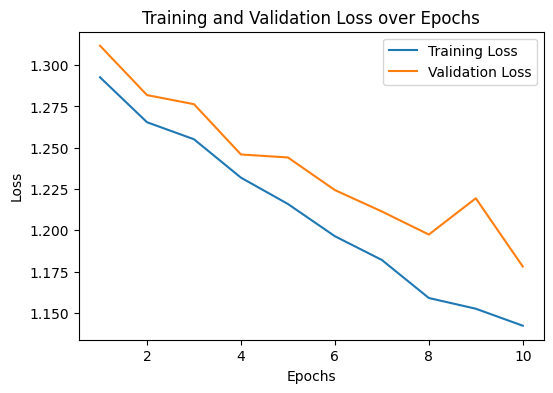

Text(0, 0.5, 'Frequency')

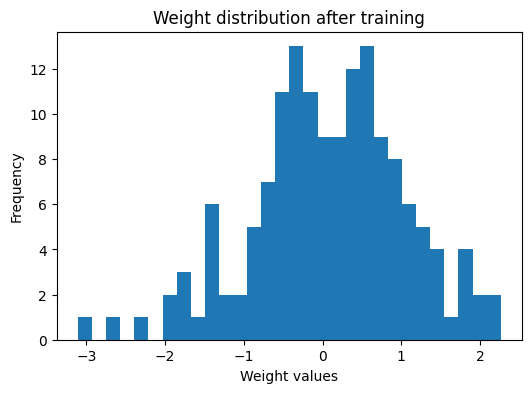

In [15]:
# plot the losses
plt.figure(figsize=(6, 4))
plt.plot(range(1, NUM_EPOCHS+1), train_loss_, label='Training Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_loss_, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

# plot the distribution of weights after training
plt.figure(figsize=(6, 4))
plt.hist(model.net[0].weight.data.numpy().flatten(), bins=30)
plt.title('Weight distribution after training')
plt.xlabel('Weight values')
plt.ylabel('Frequency')     